In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline

# GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1, 2"

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Using TensorFlow backend.


In [2]:
import prostate
dataset_dir = "/scratch/wenyuan/Mask-RCNN/Data_Pre_Processing/cedars-224"
held_out_set = 4
mean_pixel = prostate.Mean_pixel(dataset_dir, held_out_set)
class TrainConfig(prostate.ProstateConfig):
            MEAN_PIXEL = np.array(mean_pixel)
config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           prostate
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Training dataset
subset_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dataset_train = prostate.ProstateDataset()
dataset_train.load_prostate(dataset_dir, subset_1, mode = 144)
dataset_train.prepare() # prepare the dataset class for use

# Validation dataset
subset_2 = [1 , 3, 4]
dataset_val = prostate.ProstateDataset()
dataset_val.load_prostate(dataset_dir, subset_2, mode = 144)
dataset_val.prepare()

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

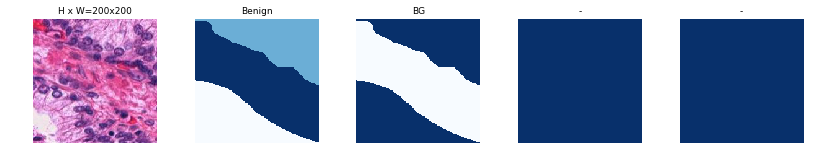

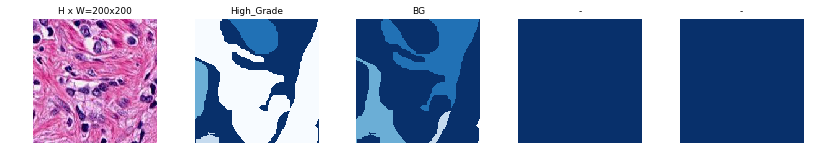

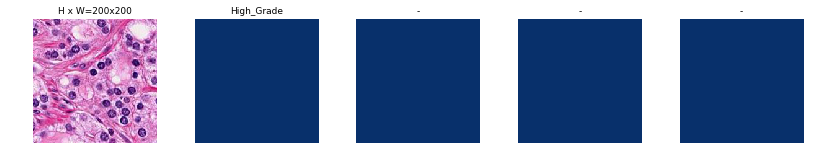

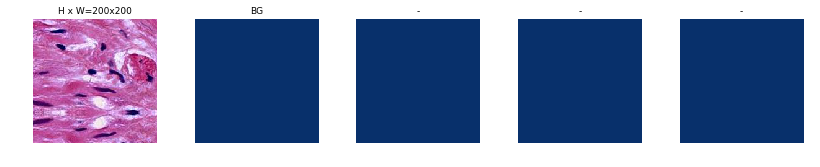

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id) # generating image
    mask, class_ids = dataset_train.load_mask(image_id) # generating mask
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /scratch/wenyuan/Mask-RCNN/Mask-RCNN-org/Mask_RCNN/logs/prostate20180129T2147/mask_rcnn_prostate_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
1000/1000 [==============================] - 988s 988ms/step - loss: 1.7206 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.3677 - mrcnn_mask_loss: 0.6163 - val_loss: 1.1413 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.2299 - val_mrcnn_class_loss: 0.1513 - val_mrcnn_bbox_loss: 0.2542 - val_mrcnn_mask_loss: 0.4985


In [10]:
model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=2,
                    layers='4+')


Starting at epoch 1. LR=0.001

Checkpoint Path: /scratch/wenyuan/Mask-RCNN/Mask-RCNN-org/Mask_RCNN/logs/prostate20180129T2147/mask_rcnn_prostate_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bra

/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
1000/1000 [==============================] - 1123s 1s/step - loss: 1.2617 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.4760 - val_loss: 1.0353 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.4214 - val_mrcnn_class_loss: 0.0526 - val_mrcnn_bbox_loss: 0.2285 - val_mrcnn_mask_loss: 0.3244


In [12]:
model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE / 10,
                    epochs=4,
                    layers='all')


Starting at epoch 2. LR=0.0001

Checkpoint Path: /scratch/wenyuan/Mask-RCNN/Mask-RCNN-org/Mask_RCNN/logs/prostate20180129T2147/mask_rcnn_prostate_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wenyuan/.conda/envs/maskrcnn/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 3/4
1000/1000 [==============================] - 1204s 1s/step - loss: 1.0233 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3430 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1943 - mrcnn_mask_loss: 0.3949 - val_loss: 0.7264 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.0922 - val_mrcnn_class_loss: 0.0648 - val_mrcnn_bbox_loss: 0.2036 - val_mrcnn_mask_loss: 0.3605
Epoch 4/4
1000/1000 [==============================] - 1192s 1s/step - loss: 0.9832 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.3771 - val_loss: 0.6644 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.0931 - val_mrcnn_class_loss: 0.0486 - val_mrcnn_bbox_loss: 0.1496 - val_mrcnn_mask_loss: 0.3682
